In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] ='4'
os.environ['PYOPENGL_PLATFORM'] = 'osmesa'
import torch
import logging
import time
from argparse import ArgumentParser

import cv2
import json_tricks as json
import numpy as np


from pose_pipeline.utils.jupyter import play,play_grid
from pose_pipeline.pipeline import BlurredVideo,LiftingPerson,LiftingMethod,TopDownPerson,Video
from multi_camera.datajoint.multi_camera_dj import PersonKeypointReconstruction,SingleCameraVideo, CalibratedRecording, MultiCameraRecording,PersonKeypointReconstructionMethod
from multi_camera.datajoint.sessions import Recording
from hand_dj import HandPoseReconstructionMethodLookup,HandPoseReconstructionMethod, HandPoseReconstruction,HandPoseEstimationMethodLookup
from hand_dj import HandBbox,HandBboxMethod, HandPoseEstimation,HandPoseEstimationMethod,HandPoseEstimationVideo

[2024-01-02 16:32:25,017][INFO]: Connecting pfirouzabadi@127.0.0.1:3306
[2024-01-02 16:32:25,054][INFO]: Connected pfirouzabadi@127.0.0.1:3306


In [8]:
vid_keys = (HandPoseEstimation & 'filename LIKE "m002%"' & 'detection_method=1').fetch('KEY')

In [55]:
participant_idx = 0
participant_videos = (Recording & 'participant_id="m002"').fetch('KEY')[participant_idx]
vid_keys= (SingleCameraVideo & participant_videos).fetch('KEY')
len(vid_keys)

12

In [56]:
for k in vid_keys:
    k['detection_method'] = 1 
len(vid_keys)

12

In [36]:
# HandBboxMethod.insert(vid_keys,skip_duplicates=True)
# HandBbox.populate()
len((HandBbox & "detection_method=1").fetch('KEY'))

72

In [57]:
for k in vid_keys:
    k['estimation_method'] = 0
len(vid_keys)

12

In [89]:
# HandPoseEstimationMethod.insert(vid_keys,skip_duplicates=True)
# HandPoseEstimation.populate()
# len((HandPoseEstimation & "detection_method=1").fetch('KEY'))
kp2d = (HandPoseEstimation&vid_keys[0]).fetch("keypoints_2d")
kp2d_r = np.asarray(kp2d[0])[:,0,:,:]
np.min(kp2d_r[:,:,-1])

0.09467043

# Visualization

In [24]:
def render_video(video, output_file, keypoints):
    cap = cv2.VideoCapture(video)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    fps = cap.get(cv2.CAP_PROP_FPS)
    output_size = (int(w),int(h))

    fourcc = cv2.VideoWriter_fourcc(*"MP4V")
    out = cv2.VideoWriter(output_file,fourcc, fps,output_size)

    for frame_idx in tqdm(range(total_frames)):
        success, frame = cap.read()

        if not success:
            break
        keypoints = keypoints[frame_idx,:,:].copy()
        frame = draw_keypoints(frame,keypoints)
        out.write(frame)

    out.release()
    cap.release()

In [91]:

num_cameras = len(vid_keys)
num_cameras

12

In [140]:
%matplotlib inline
def plot_all_cameras(key, frame_idx = 0,n_cols=3):
    # using the variable axs for multiple Axes
    from pose_pipeline.utils.visualization import draw_keypoints
    
    
    vid_keys = (SingleCameraVideo & key).fetch('KEY')
    num_cameras = len(vid_keys)
    
    
    fig, axs = plt.subplots(num_cameras//n_cols,n_cols,figsize=(15,15))
    for vid_idx in range(num_cameras):
        vid_file = ( Video & vid_keys[vid_idx]).fetch('video')[0]
        # output_file = f'{output_root}m002_camera{vid_idx}.mp4'
        
        cap = cv2.VideoCapture(vid_file)
        frame_idx = 0
        # video_writer = None
        # pred_instances_list = []
        keypoints_2d = (HandPoseEstimation & vid_keys[vid_idx]).fetch1("keypoints_2d")
        ###############################CHOOSE A FRAME#########################
        # while frame_idx < 1:
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        success, frame = cap.read()
        frame_idx += 1

        if not success:
            break
        # radius = 10
        # threshold = 0.2
        # color = (255,255,255)
        # border_color = (0,0,0)
        for k in keypoints_2d[frame_idx]:
            keypoints = k[:,:].copy()
            frame = draw_keypoints(frame,keypoints)

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        row = vid_idx // n_cols
        col = vid_idx % n_cols
        axs[row,col].imshow(frame)
        os.remove(vid_file)

In [90]:
# key = ( CalibratedRecording &  ((Recording & 'participant_id="m002"').fetch('KEY'))).fetch('KEY')
# for k in key:
#     k['reconstruction_method']=3
#     k['estimation_method']=0
#     k['detection_method']=1

# HandPoseReconstructionMethod.insert(key,skip_duplicates=True)
HandPoseReconstruction.populate(key)


CAMERAS 12
Robust Triangulation $\\gamma=0.3$
CAMERAS 12
Robust Triangulation $\\gamma=0.3$
CAMERAS 12
Robust Triangulation $\\gamma=0.3$
CAMERAS 12
Robust Triangulation $\\gamma=0.3$


In [47]:
HandPoseEstimationVideo.populate()

100%|██████████| 925/925 [00:14<00:00, 63.79it/s]


# Export to TRC files


In [2]:
HandPoseReconstruction()

recording_timestamps,camera_config_hash,cal_timestamp,reconstruction_method,estimation_method,detection_method,keypoints3d,camera_weights,reprojection_loss
2023-09-26 11:07:17,0cbbed837e,2023-09-26 11:11:27,0,0,1,=BLOB=,=BLOB=,12.418
2023-09-26 11:07:17,0cbbed837e,2023-09-26 11:11:27,3,0,1,=BLOB=,=BLOB=,8.55241
2023-09-26 11:08:13,0cbbed837e,2023-09-26 11:11:27,0,0,1,=BLOB=,=BLOB=,8.80644
2023-09-26 11:08:50,0cbbed837e,2023-09-26 11:11:27,0,0,1,=BLOB=,=BLOB=,2388.21
2023-11-15 14:45:52,6222d5655b,2023-11-15 14:49:30,0,0,1,=BLOB=,=BLOB=,8.32496
2023-11-15 14:45:52,6222d5655b,2023-11-15 14:49:30,3,0,1,=BLOB=,=BLOB=,3.61205
2023-11-15 14:46:31,6222d5655b,2023-11-15 14:49:30,0,0,1,=BLOB=,=BLOB=,8.52439
2023-11-15 14:46:31,6222d5655b,2023-11-15 14:49:30,3,0,1,=BLOB=,=BLOB=,3.47692
2023-11-15 14:47:09,6222d5655b,2023-11-15 14:49:30,0,0,1,=BLOB=,=BLOB=,8.90134
2023-11-15 14:47:09,6222d5655b,2023-11-15 14:49:30,3,0,1,=BLOB=,=BLOB=,2.08844


# Populate and export trc


In [106]:
participant_idx = 0
participant_id="m002"
participant_videos = (Recording & f'participant_id="m002"').fetch('KEY')[participant_idx]
reconstruction_method = 3

key = (CalibratedRecording &  participant_videos).fetch('KEY')
for k in key:
    k['reconstruction_method']= reconstruction_method
    k['estimation_method']=0
    k['detection_method']=1


In [94]:

# HandPoseReconstructionMethod.insert(key,skip_duplicates=True)
HandPoseReconstruction.populate(key)


In [100]:
output_file= f'{participant_id}_{participant_idx}_reconstructed_{reconstruction_method}_w_movi.trc'
HandPoseReconstruction.export_trc((HandPoseReconstruction & key ), output_file, z_offset=0,addMovi=True,smooth=True)

In [108]:
(HandPoseReconstruction & key ).fetch("reprojection_loss")

array([3.61205])

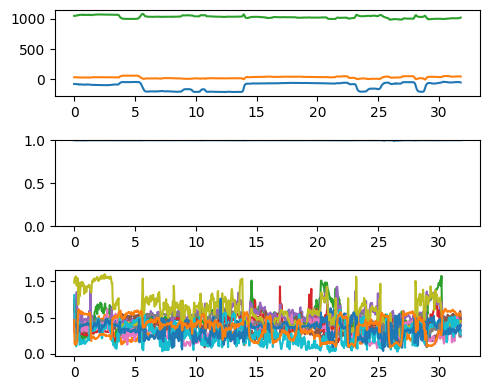

In [111]:
HandPoseReconstruction.plot_joint((HandPoseReconstruction & key ),2)

In [142]:
plot_all_cameras(key, frame_idx = 0)

UnboundLocalError: local variable 'num_cameras' referenced before assignment